# Transect of results and observations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import xarray as xr
import cmocean
import pandas as pd 
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import warnings
warnings.filterwarnings('ignore')
import pickle
import forcing.modules.mapping_functions as mf
import glob
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

%matplotlib inline

#### Parameters:

In [6]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

isize = imax-imin
jsize = jmax-jmin

# results to plot:
year    = 2002
month   = 8
results_folder = '/data/brogalla/run_storage/Pb-new-ini2-spin1/'

# colours:
land_color     = '#a9a7a2'
profile_colors = ['#ff4949', '#01b9ff']

#### Files:

In [3]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
ANHA12_lon   = mfile['nav_lon'].values
ANHA12_lat   = mfile['nav_lat'].values
tmask        = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
bathy_masked = np.ma.masked_where((tmask> 0.1), tmask) 
mesh_depth   = mfile['nav_lev'].values

In [4]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdept = np.array(mesh.variables['hdept'][0,imin:imax,jmin:jmax])

In [7]:
file1        = 'ANHA12_EXH006_1m_20020101_20021231_comp_200208-200208.nc' #'ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20021222-20021226.nc'
Pb_model     = nc.Dataset(f'{results_folder}{file1}')
Pb_dis       = np.array(Pb_model.variables['dissolpb'])[0,:,:,:]
sub_lat      = np.array(Pb_model.variables['nav_lat'])
sub_lon      = np.array(Pb_model.variables['nav_lon'])
depths_model = np.array(Pb_model.variables['deptht'])

Observations

In [8]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

Pb_data = Pb_data.rename(columns={"Depth.1": "Depth BB1", "Depth.2": "Depth BB2", "Depth.3": "Depth BB3", \
                        "Depth.4": "Depth CAA1", "Depth.5": "Depth CAA2", "Depth.6": "Depth CAA3", \
                        "Depth.7": "Depth CAA4", "Depth.8": "Depth CAA5", "Depth.9": "Depth CAA6", \
                        "Depth.10": "Depth CAA7", "Depth.11": "Depth CAA8", "Depth.12": "Depth CAA9", \
                        "Depth.13": "Depth CB1", "Depth.14": "Depth CB2", "Depth.15": "Depth CB3", \
                        "Depth.16": "Depth CB4"})

In [9]:
stn_names = Pb_data['Station names'].dropna().astype('str')
obs_lons  = Pb_data['station lon'].astype('float').dropna().values
obs_lats  = Pb_data['Station lat'].astype('float').dropna().values

#### Functions:

In [10]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [11]:
def fill_nans(input_var):
    vector = np.zeros(24)
    for i in range(0,24):
        if i < len(input_var):
            vector[i] = input_var[i]
        else:
            vector[i] = np.nan
    return vector

In [12]:
def search_depth(obs_depth, model_depths):
    k_list = np.array([])
    for i in range(0,len(obs_depth)):
        diff_list = np.array([])
        for n in range(0, len(model_depths)):
            diff = np.abs(obs_depth[i] - model_depths[n])
            diff_list = np.append(diff_list, diff)
        k = np.argmin(diff_list) # for list of indices associated with depths
        k_list = np.append(k_list, k)
    return k_list

#### Figure of transect along stations:

In [13]:
transect_names = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', '', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3', \
                 '', 'BB3', '', 'BB1']

transect_distances = np.zeros(len(transect_names))
transect_lons      = np.zeros(len(transect_names)); transect_lats = np.zeros(len(transect_names));
transect_dPb       = np.zeros((26,len(transect_names)))
transect_depths    = np.zeros((26,len(transect_names)))
for k,name in enumerate(transect_names):
    if name=='' and k < 8:
        transect_lons[k] = -95.128357
        transect_lats[k] = 74.313002
    elif name=='' and k > 8 and k < 14:
        transect_lons[k] = -76.495545
        transect_lats[k] = 73.658423
    elif name=='' and k >= 14:        
        transect_lons[k] = -63.927186
        transect_lats[k] = 70.355341
    else:
        transect_lons[k] = obs_lons[stn_names==name]
        transect_lats[k] = obs_lats[stn_names==name]
    
    transect_distances[k] = haversine(transect_lons[0], transect_lats[0], transect_lons[k], transect_lats[k])
    try:
        transect_dPb[:,k]     = Pb_data[name].astype('float').values
        transect_depths[:,k]  = Pb_data[f'Depth {name}'].astype('float').values
    except:
        transect_dPb[:,k]     = np.nan
        transect_depths[:,k]  = np.nan
            
transect_depths_r = transect_depths[::-1, :] #reversed order so that surface points are stacked on top
transect_dPb_r    = transect_dPb[::-1, :] 

In [14]:
# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

In [15]:
# Find Pb model grid point coordinates associated with the array of points:
transect_i, transect_j = mf.find_indeces_vector(transect_vlons, transect_vlats, sub_lon, sub_lat)

transect_model_distances = np.array([])
transect_model_hdept     = np.array([])
transect_dissolved_pb    = np.zeros((len(depths_model), len(transect_vlons)))
# Gather model results and bathymetry for the array of points
for n in range(0,len(transect_vlons)):
    distance_model = haversine(sub_lon[int(transect_i[0]), int(transect_j[0])],\
                               sub_lat[int(transect_i[0]), int(transect_j[0])],\
                               sub_lon[int(transect_i[n]), int(transect_j[n])],\
                               sub_lat[int(transect_i[n]), int(transect_j[n])])
    transect_model_distances = np.append(transect_model_distances, distance_model)
    transect_model_hdept     = np.append(transect_model_hdept, mesh_hdept[int(transect_i[n]), int(transect_j[n])])
    
    transect_dissolved_pb[:,n] = Pb_dis[:,int(transect_i[n]), int(transect_j[n])]

In [16]:
transect_names2       = np.copy(transect_names).astype('<U9')
transect_names2[5:-3] = ''
transect_names2[5]    = 'CAA4-7'
transect_names2[10]   = 'CAA1-3'

[None, None, None, None, None, None, None, None]

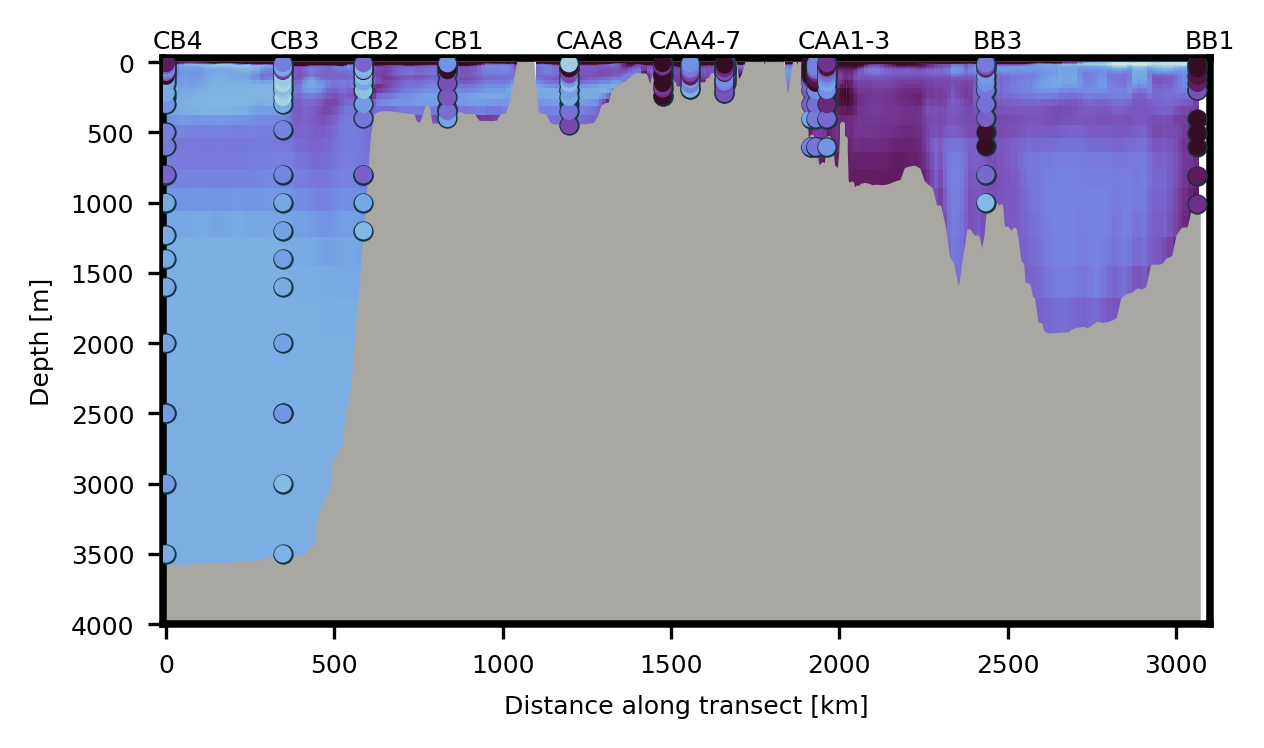

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4.5, 2.5), dpi=300)

# limits for colorbar:
vminPb = 0 
vmaxPb = 10
pointsbg = '#173543'# outline color for scatterpoints

# plot stations:
for i in range(0,len(transect_lons)):
    ax.scatter(transect_distances[i]*np.ones(26), transect_depths_r[:,i], \
                       vmin = vminPb, vmax = vmaxPb, c=pointsbg, zorder= 3, s=15)
    sc = ax.scatter(transect_distances[i]*np.ones(26), transect_depths_r[:,i], \
                       vmin = vminPb, vmax = vmaxPb, c=transect_dPb_r[:,i]*10**3, cmap=cmocean.cm.dense,\
                       zorder = 3, s=10)
    ax.text(transect_distances[i]-40, -100, transect_names2[i], fontsize=6)
    
ax.invert_yaxis()
contour = ax.pcolormesh(transect_model_distances, depths_model, transect_dissolved_pb*10**(12), \
                   vmin=vminPb, vmax=vmaxPb, cmap=cmocean.cm.dense, zorder=2)
# ax.plot(transect_distances, transect_bathy, c=land_color)
ax.fill_between(transect_model_distances, 4000, transect_model_hdept, color=land_color, zorder=2)
ax.set_ylabel('Depth [m]', fontsize=6)
ax.set_xlabel('Distance along transect [km]', fontsize=6)
ax.set_ylim([4000, -30])
ax.set_xlim([-8, 3100])
ax.tick_params(axis='both', which='major', labelsize=6)
plt.setp(ax.spines.values(), linewidth=1.8, color='k')

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/R1-transect_evaluation-20200327.png', bbox_inches='tight', dpi=300)